<a href="https://colab.research.google.com/github/Justin-Jonany/AutoPartner/blob/main/autopartner_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoPartner
This dataset is retrieved from https://www.kaggle.com/datasets/deepcontractor/car-price-prediction-challenge/data.

### Goal
The goal of this notebook is to create an effective model to predict car sales price.

### Attributes
1. ID
2. Price: price of the care(Target Column)
3. Levy
4. Manufacturer
5. Model
6. Prod. year
7. Category
8. Leather interior
9. Fuel type
10. Engine volume
11. Mileage
12. Cylinders
13. Gear box type
14. Drive wheels
15. Doors
16. Wheel
17. Color
18. Airbags

## Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Ridge, Lasso, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

from joblib import load, dump
import seaborn as sns

In [ ]:
# Setting all data to be displayed with 3 decimal places (prevents scientific notations)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
df = pd.read_csv("car_price_prediction.csv")
df.shape

(19237, 18)

In [ ]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.000,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.000,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.000,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.000,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.000,Automatic,Front,04-May,Left wheel,Silver,4


In [ ]:
df.tail()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
19232,45798355,8467,-,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000 km,4.000,Manual,Rear,02-Mar,Left wheel,Silver,5
19233,45778856,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.000,Tiptronic,Front,04-May,Left wheel,Red,8
19234,45804997,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,116365 km,4.000,Automatic,Front,04-May,Left wheel,Grey,4
19235,45793526,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,51258 km,4.000,Automatic,Front,04-May,Left wheel,Black,4
19236,45813273,470,753,HYUNDAI,Sonata,2012,Sedan,Yes,Hybrid,2.4,186923 km,4.000,Automatic,Front,04-May,Left wheel,White,12


### Splitting Data Into Training and Test Set Before EDA
we need to classify the **Price** column into a few categories in order to **stratify split** the data.

In [ ]:
df["Price_cat"] = pd.cut(df["Price"],
                               bins=[0., 4000, 8000, 12000, 14000, 18000, np.inf],
                               labels=[1, 2, 3, 4, 5, 6])

In [ ]:
df.Price_cat.value_counts()

Price_cat
6    6681
1    4174
3    2584
5    2429
2    2228
4    1141
Name: count, dtype: int64

In [ ]:
df.shape

(19237, 19)

In [ ]:
df_train, df_test = train_test_split(df, stratify=df['Price_cat'], test_size=0.2)
df_train.shape, df_test.shape

((15389, 19), (3848, 19))

In [ ]:
df_train.Price_cat.value_counts(len(df_train))

Price_cat
6   0.347
1   0.217
3   0.134
5   0.126
2   0.116
4   0.059
Name: proportion, dtype: float64

In [ ]:
df_test.Price_cat.value_counts(len(df_test))

Price_cat
6   0.347
1   0.217
3   0.134
5   0.126
2   0.116
4   0.059
Name: proportion, dtype: float64

Both training and testing set have proportional target labels, so now we can remove `Price_label` from both sets

In [ ]:
df_test.drop('Price_cat', axis=1, inplace=True);
df_train.drop('Price_cat', axis=1, inplace=True);

## EDA
For now, let's set aside the testing set, and explore training set. However, we make a copy of it before doing anything else.

In [ ]:
df_eda = df_train.copy()

In [ ]:
df_eda.shape

(15389, 18)

In [ ]:
for col in df_eda.columns:
    print(col)
    print(df_eda[f'{col}'].unique())
    print('*'*75)

ID
[45730869 45762934 45651193 ... 45801436 45793131 45768505]
***************************************************************************
Price
[43868   282   706 ... 12676  9060   345]
***************************************************************************
Levy
['730' '640' '394' '765' '-' '639' '831' '645' '781' '2225' '642' '1325'
 '1399' '891' '583' '1055' '2410' '1266' '707' '784' '880' '584' '836'
 '843' '1624' '441' '1646' '1011' '986' '308' '1493' '364' '1598' '1514'
 '502' '753' '531' '1172' '779' '607' '810' '760' '1694' '1301' '917'
 '697' '862' '586' '919' '1249' '1537' '1811' '629' '3273' '1296' '2455'
 '749' '1327' '1363' '1053' '609' '1236' '1356' '934' '1273' '761' '687'
 '834' '690' '585' '1017' '503' '475' '1051' '738' '777' '915' '382'
 '1750' '650' '769' '2108' '528' '1360' '1268' '1194' '1058' '1282' '505'
 '473' '966' '418' '2266' '832' '530' '1234' '1091' '1080' '751' '1077'
 '1267' '1095' '1408' '345' '562' '1148' '1104' '1197' '521' '1807' '1391'
 '259' '1

In [ ]:
df_eda.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
9974,45730869,43868,730,SSANGYONG,Actyon,2016,Jeep,Yes,Diesel,1.6,42819 km,4.000,Automatic,Front,04-May,Left wheel,Black,4
2284,45762934,282,640,AUDI,A4,2013,Sedan,Yes,Petrol,2,157584 km,4.000,Automatic,4x4,04-May,Left wheel,Black,0
18015,45651193,706,394,TOYOTA,Camry,2014,Sedan,Yes,Hybrid,2.5,115312 km,4.000,Automatic,Front,04-May,Left wheel,Grey,12
4394,45803351,9252,765,HYUNDAI,Sonata,2015,Sedan,Yes,LPG,2,603446 km,4.000,Automatic,Front,04-May,Left wheel,Orange,4
16472,42809468,8154,-,HONDA,FIT,2005,Hatchback,No,Petrol,1.3,117000 km,4.000,Automatic,Front,04-May,Right-hand drive,Silver,4


In [ ]:
df_eda.tail()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
19056,45802290,44843,1091,HYUNDAI,H1,2016,Universal,Yes,Diesel,2.5,133687 km,4.000,Automatic,Front,04-May,Left wheel,Grey,4
10096,45590050,31361,-,MERCEDES-BENZ,Sprinter,2004,Microbus,Yes,Diesel,2.7 Turbo,200000 km,5.000,Manual,Rear,02-Mar,Left wheel,White,2
11122,45801436,15035,528,HYUNDAI,Accent,2014,Sedan,Yes,Diesel,1.6,181232 km,4.000,Automatic,Front,04-May,Left wheel,Grey,4
12270,45793131,6429,961,CHEVROLET,Cruze,2009,Sedan,Yes,Diesel,2,66287 km,4.000,Automatic,Front,04-May,Left wheel,Black,4
19097,45768505,7213,-,LAND ROVER,Range Rover,1997,Jeep,Yes,Diesel,2.5 Turbo,111111 km,6.000,Manual,4x4,04-May,Left wheel,Black,12


In [ ]:
df_eda.info();

<class 'pandas.core.frame.DataFrame'>
Index: 15389 entries, 9974 to 19097
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                15389 non-null  int64  
 1   Price             15389 non-null  int64  
 2   Levy              15389 non-null  object 
 3   Manufacturer      15389 non-null  object 
 4   Model             15389 non-null  object 
 5   Prod. year        15389 non-null  int64  
 6   Category          15389 non-null  object 
 7   Leather interior  15389 non-null  object 
 8   Fuel type         15389 non-null  object 
 9   Engine volume     15389 non-null  object 
 10  Mileage           15389 non-null  object 
 11  Cylinders         15389 non-null  float64
 12  Gear box type     15389 non-null  object 
 13  Drive wheels      15389 non-null  object 
 14  Doors             15389 non-null  object 
 15  Wheel             15389 non-null  object 
 16  Color             15389 non-null  object 


### Converting the non-interger/non-float numerical attributes and cleaning data
The attributes we're converting:
* **Levy**
* **Engine volume**
* **Mileage**
* **Doors**

In [ ]:
df_eda.Levy.value_counts()

Levy
-       4665
765      386
891      364
639      328
640      314
        ... 
2421       1
2913       1
1118       1
3268       1
1361       1
Name: count, Length: 516, dtype: int64

In [ ]:
# Replacing '-' with null
df_eda['Levy'].replace({'-':np.nan}, inplace = True)
# Converting Levy type to float
df_eda['Levy'] = df_eda['Levy'].astype('float64')

In [ ]:
df_eda['Engine volume'].values

array(['1.6', '2', '2.5', ..., '1.6', '2', '2.5 Turbo'], dtype=object)

We need to remove the word "Turbo" from `Engine volume` column and convert it to int. We add another column for "Turbo" that has a 1 for True and 0 for false

In [ ]:
df_eda['Turbo'] = [(1 if len(s) > 3 else 0) for s in df_eda['Engine volume']]
df_eda['Engine volume'] = [s[:3] for s in df_eda['Engine volume']]
df_eda['Engine volume'] = df_eda['Engine volume'].astype(float)

In [ ]:
df_eda['Engine volume'].values

array([1.6, 2. , 2.5, ..., 1.6, 2. , 2.5])

In [ ]:
df_eda['Mileage'].values

array(['42819 km', '157584 km', '115312 km', ..., '181232 km', '66287 km',
       '111111 km'], dtype=object)

We need to remove the metric 'km' from the `Mileage` column and convert it to int

In [ ]:
df_eda['Mileage'] = [s[:len(s) - 2] for s in df_eda['Mileage']]
df_eda['Mileage'] = df_eda['Mileage'].astype(int)

In [ ]:
df_eda['Mileage'].values

array([ 42819, 157584, 115312, ..., 181232,  66287, 111111])

In [ ]:
df_eda['Levy'].dtype, df_eda['Engine volume'].dtype, df_eda['Mileage'].dtype

(dtype('float64'), dtype('float64'), dtype('int64'))

The Doors attributes needs to be cleaned.

In [ ]:
df_eda.Doors.value_counts()

Doors
04-May    14653
02-Mar      633
>5          103
Name: count, dtype: int64

We need to convert 04-May to 04-05, and 02-Mar

In [ ]:
df_eda['Doors'].replace({'04-May':4, '02-Mar':2, '>5':5}, inplace=True)

In [ ]:
df_eda.Doors.value_counts()

Doors
4    14653
2      633
5      103
Name: count, dtype: int64

In [ ]:
NUM_ATTRIBS = ['Price', 'Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Doors', 'Airbags']
CAT_ATTRIBS = ['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel', 'Color', 'Turbo']

### Visualizing Our Data

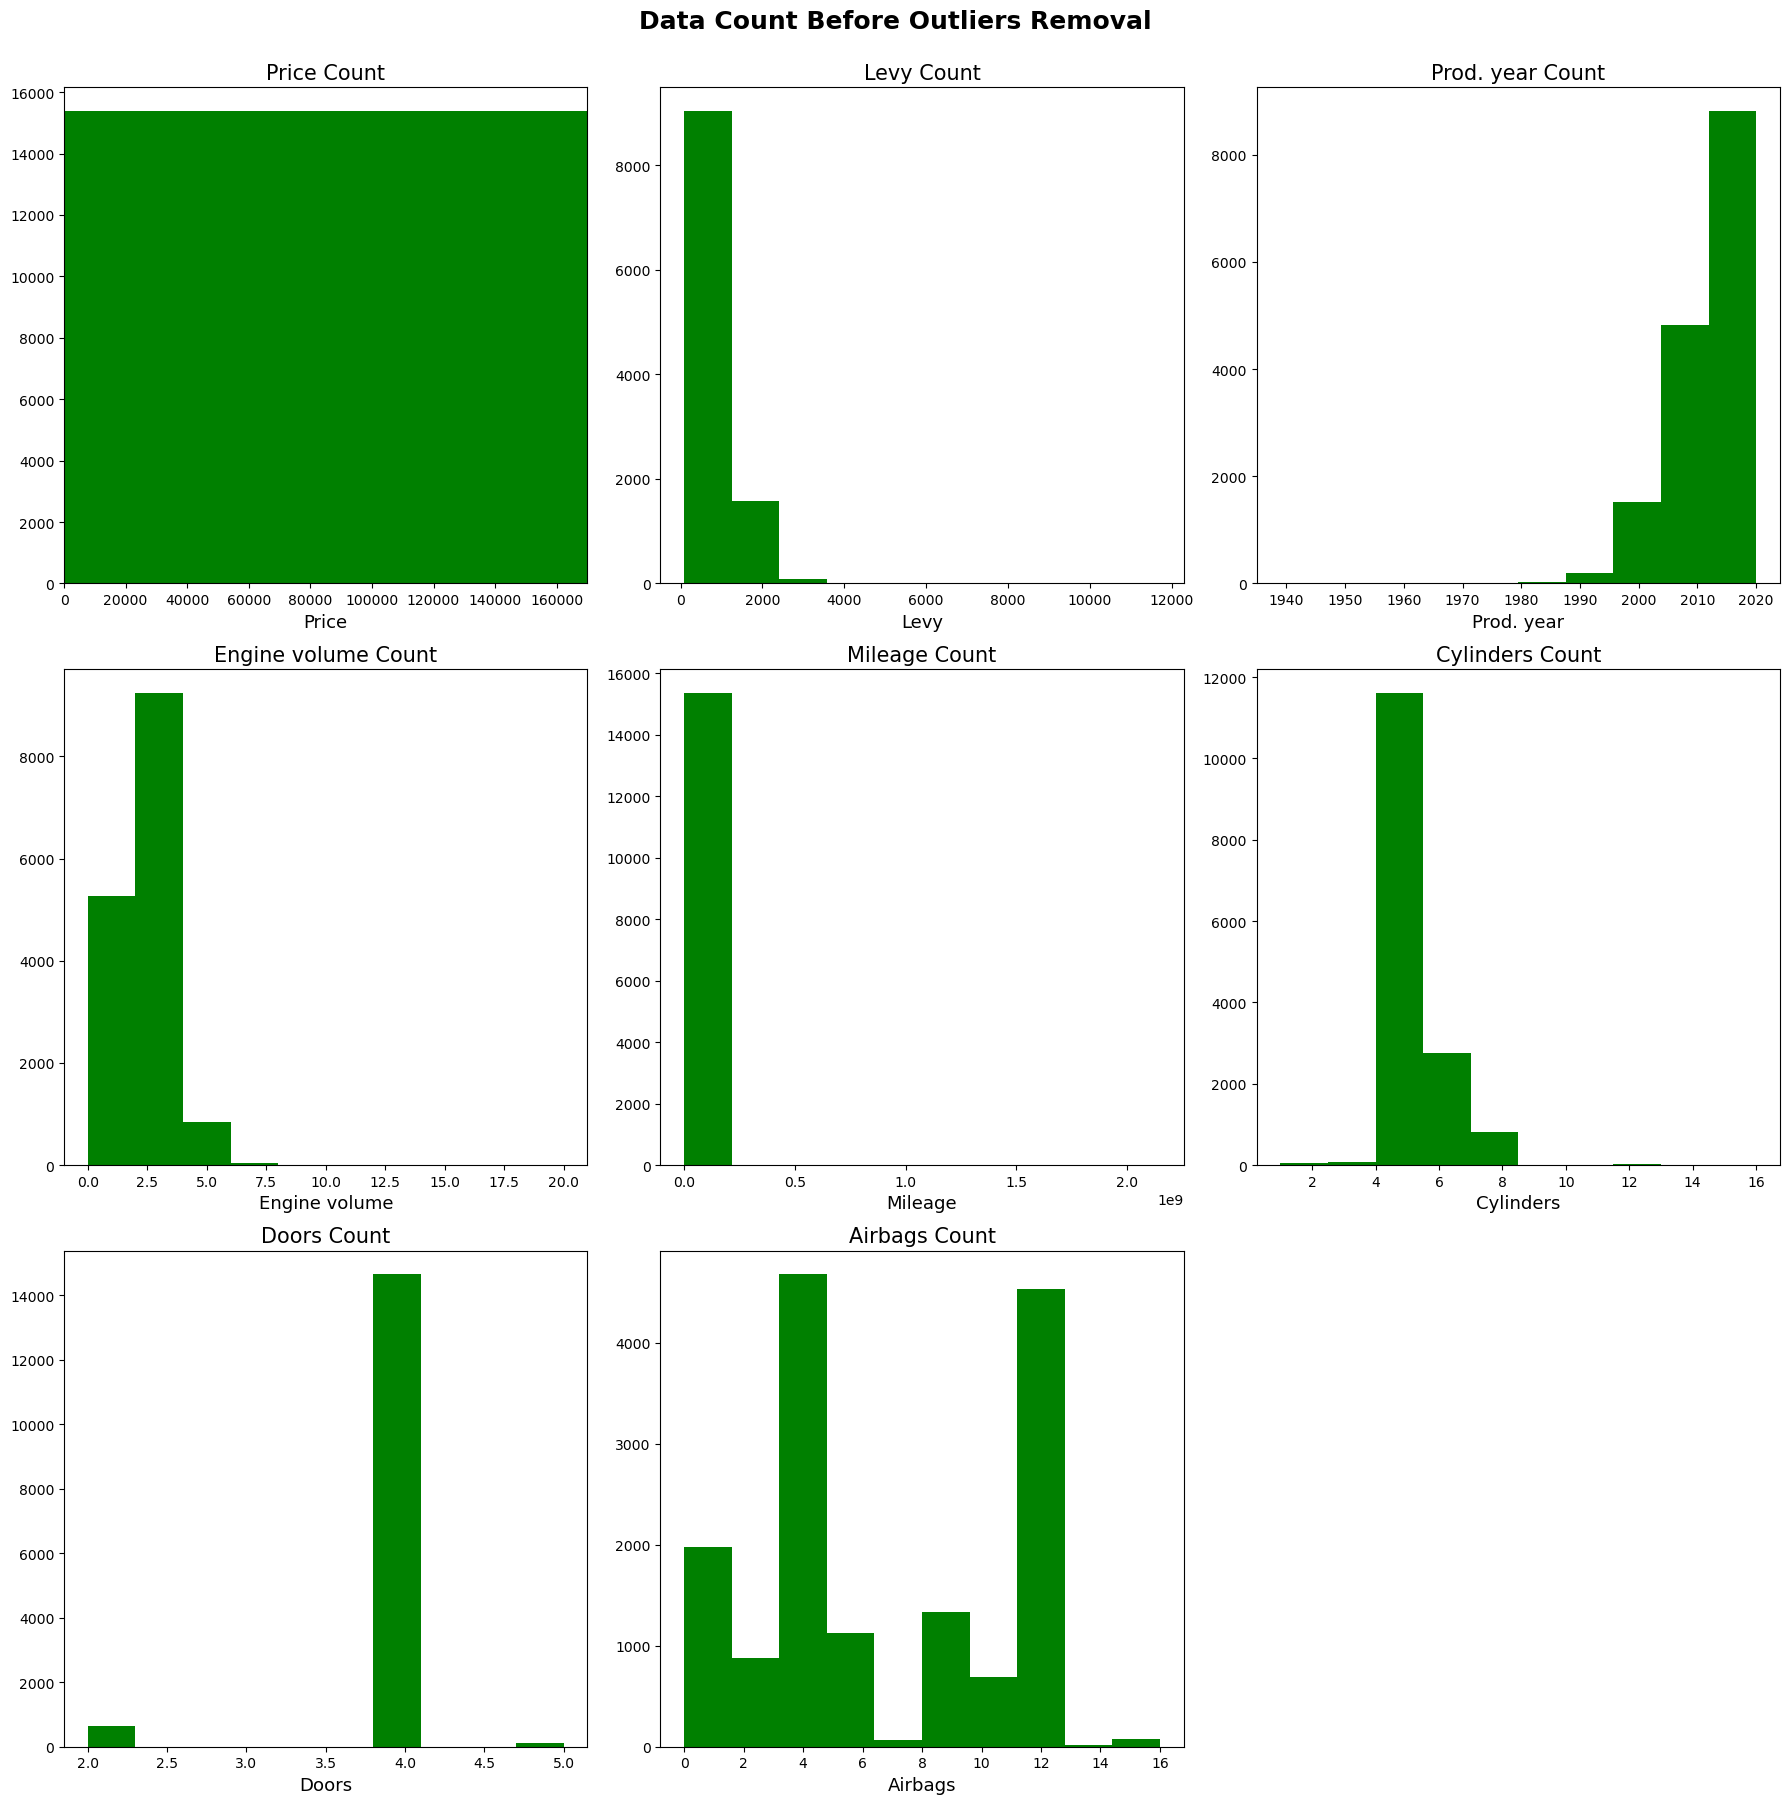

In [ ]:
fig = plt.figure(figsize=(18,18))
fig.suptitle('Data Count Before Outliers Removal', fontweight='bold', fontsize=18, y=1)

for i in range(8):
    # Create subplots (4 rows, 2 columns)
    ax = plt.subplot(3, 3, i + 1)
    # Display an image
    plt.hist(df_eda[NUM_ATTRIBS[i]], color='Green')
    plt.title(NUM_ATTRIBS[i] + ' Count', fontsize=15)
    plt.xlabel(NUM_ATTRIBS[i], fontsize=13)
    if NUM_ATTRIBS[i] == 'Price':
        plt.xlim(0, 170000)

plt.tight_layout(h_pad=1.0)
plt.show()


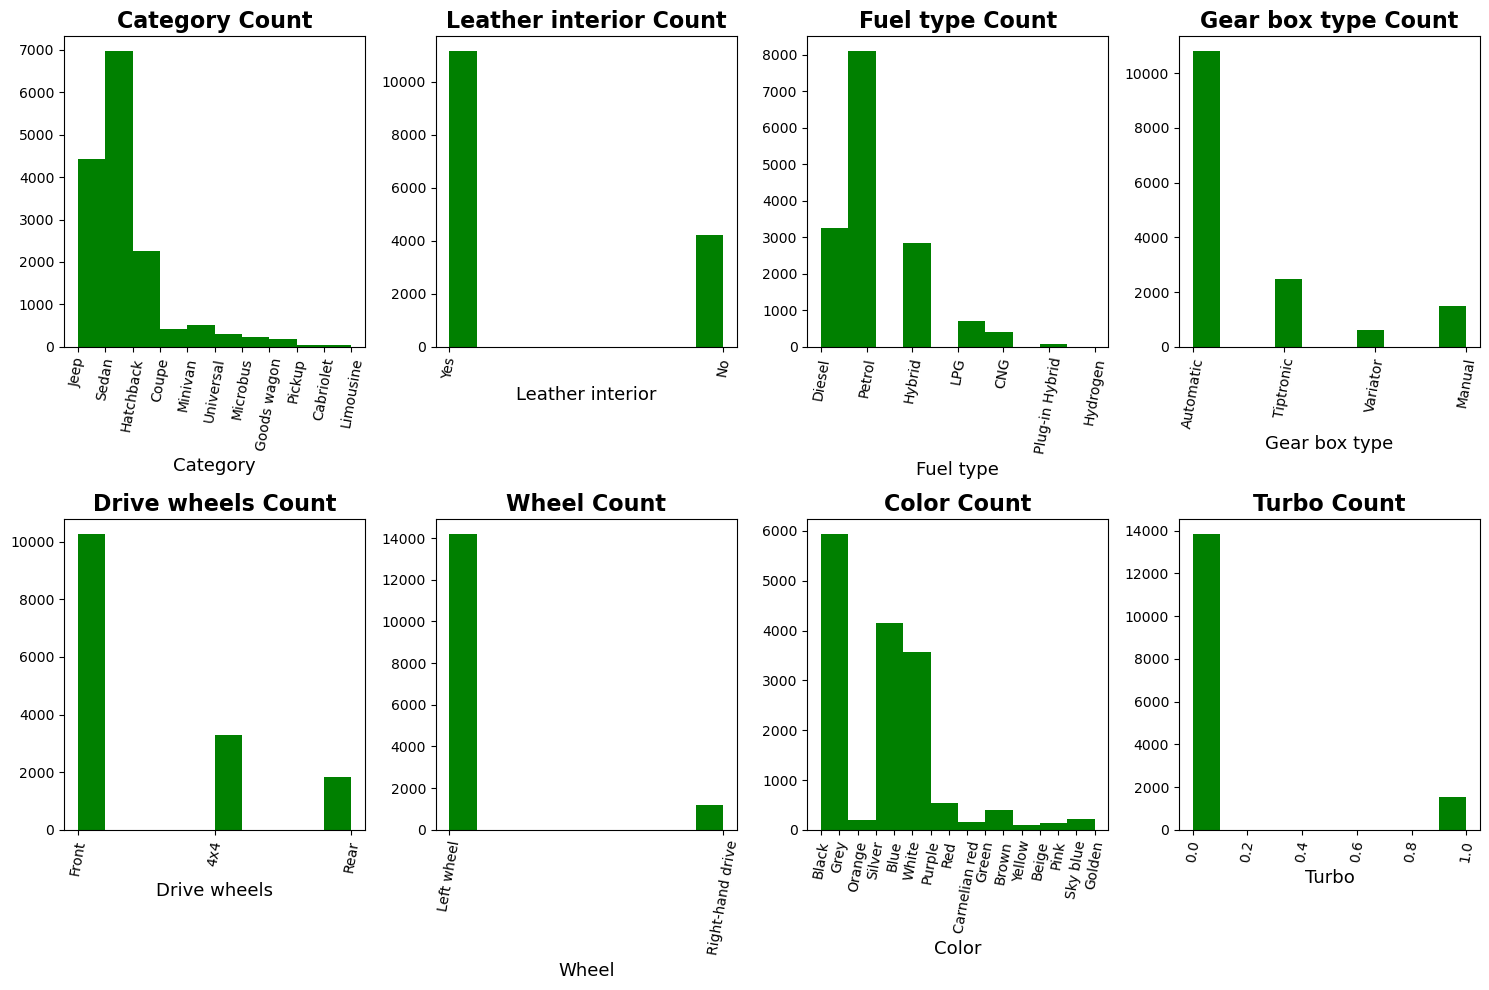

In [ ]:
plt.figure(figsize=(15,10))
attribs = CAT_ATTRIBS.copy()
attribs = CAT_ATTRIBS.copy()
attribs.remove('Manufacturer')
attribs.remove('Model')

for i in range(len(attribs)):
    ax = plt.subplot(2, 4, i + 1)
    # Display an image
    plt.hist(df_eda[attribs[i]], color='Green')
    plt.title(attribs[i] + ' Count', fontweight='bold', fontsize=16)
    plt.xlabel(attribs[i], fontsize=13)
    plt.xticks(rotation=80)


plt.tight_layout(h_pad=1.0)
plt.show()


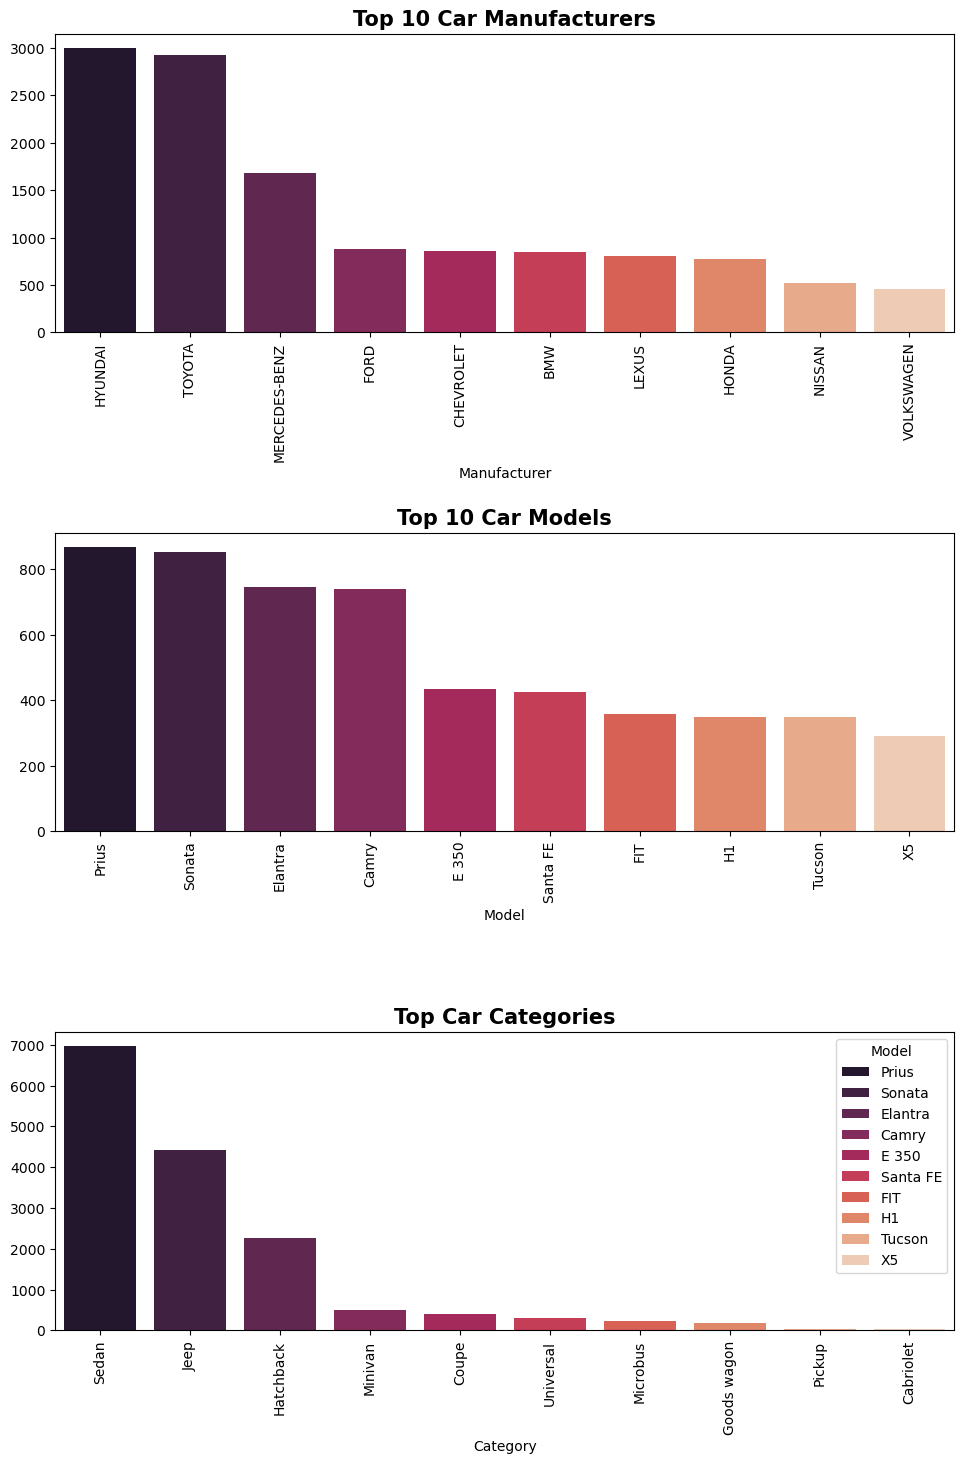

In [ ]:
manufacturers_data = df_eda['Manufacturer'].value_counts().sort_values(ascending=False)[:10]
model_data = df_eda['Model'].value_counts().sort_values(ascending=False)[:10]
category_data = df_eda['Category'].value_counts().sort_values(ascending=False)[:10]

fig = plt.figure(figsize=(10,15))
ax = plt.subplot(311)
sns.barplot(x=manufacturers_data.index, y=manufacturers_data.values, palette='rocket', hue = manufacturers_data.index);
plt.xticks(rotation=90);
plt.title('Top 10 Car Manufacturers', fontsize=15, fontweight='bold')

ax = plt.subplot(312)
sns.barplot(x=model_data.index, y=model_data.values, palette='rocket', hue = model_data.index);
plt.xticks(rotation=90);
plt.title('Top 10 Car Models', fontsize=15, fontweight='bold');

ax = plt.subplot(313)
sns.barplot(x=category_data.index, y=category_data.values, palette='rocket', hue = model_data.index);
plt.xticks(rotation=90);
plt.title('Top Car Categories', fontsize=15, fontweight='bold');
plt.tight_layout(pad=2.0)
plt.show()


The **Mileage Count** seems odd, and the data seems to have a lot of outliers

In [ ]:
df_eda["Mileage_Cat"] = pd.cut(df_eda["Mileage"],
                               bins=[0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, np.inf],
                               labels=np.arange(1, 12, 1))

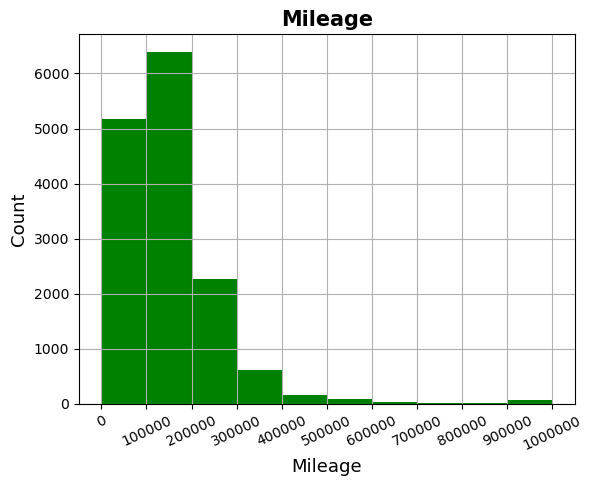

In [ ]:
df_eda['Mileage_Cat'].hist(color='green')
plt.xticks(np.arange(1, 12, 1), np.arange(0, 1100000, 100000), rotation=25);
plt.title('Mileage', fontweight='bold', fontsize=15)
plt.xlabel('Mileage', fontsize=13)
plt.ylabel('Count', fontsize=13);

In [ ]:
df_eda['Mileage'].value_counts().sort_index()[-20:]

Mileage
3552100       1
4000000       1
5451812       1
5555551       1
6768388       1
7777787       1
7789999       1
11111111      2
12648846      1
18065445      1
20000000      2
23000000      1
40000000      1
58008888      1
222222222     1
777777777     1
999999999     5
1111111111    2
1777777778    1
2147483647    5
Name: count, dtype: int64

There seems to be a lot of outliers in the mileage data like 999999999 or even 2147483647, which **doesn't make sense**

### Let's remove the outliers so we can analyze our data better
We're going to detect and remove outliers with the IQR method for features:
* **Mileage**
* **Price**
* **Levy**

In [ ]:
def detect_outliers(df,features,thold):
    outlier_indices = []

    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * thold
        # Detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # Store indeces
        outlier_indices.extend(outlier_list_col)


    return outlier_indices

In [ ]:
features = ['Price', 'Levy', 'Mileage']
outliers = detect_outliers(df_eda,features, 1.5)
deleted_df = df_eda.drop(df_eda.loc[outliers].index,axis=0)
print(f'Removed {len(df_eda) - len(deleted_df)} instances')

Removed 1381 instances


In [ ]:
df_eda.shape, deleted_df.shape

((15389, 20), (14008, 20))

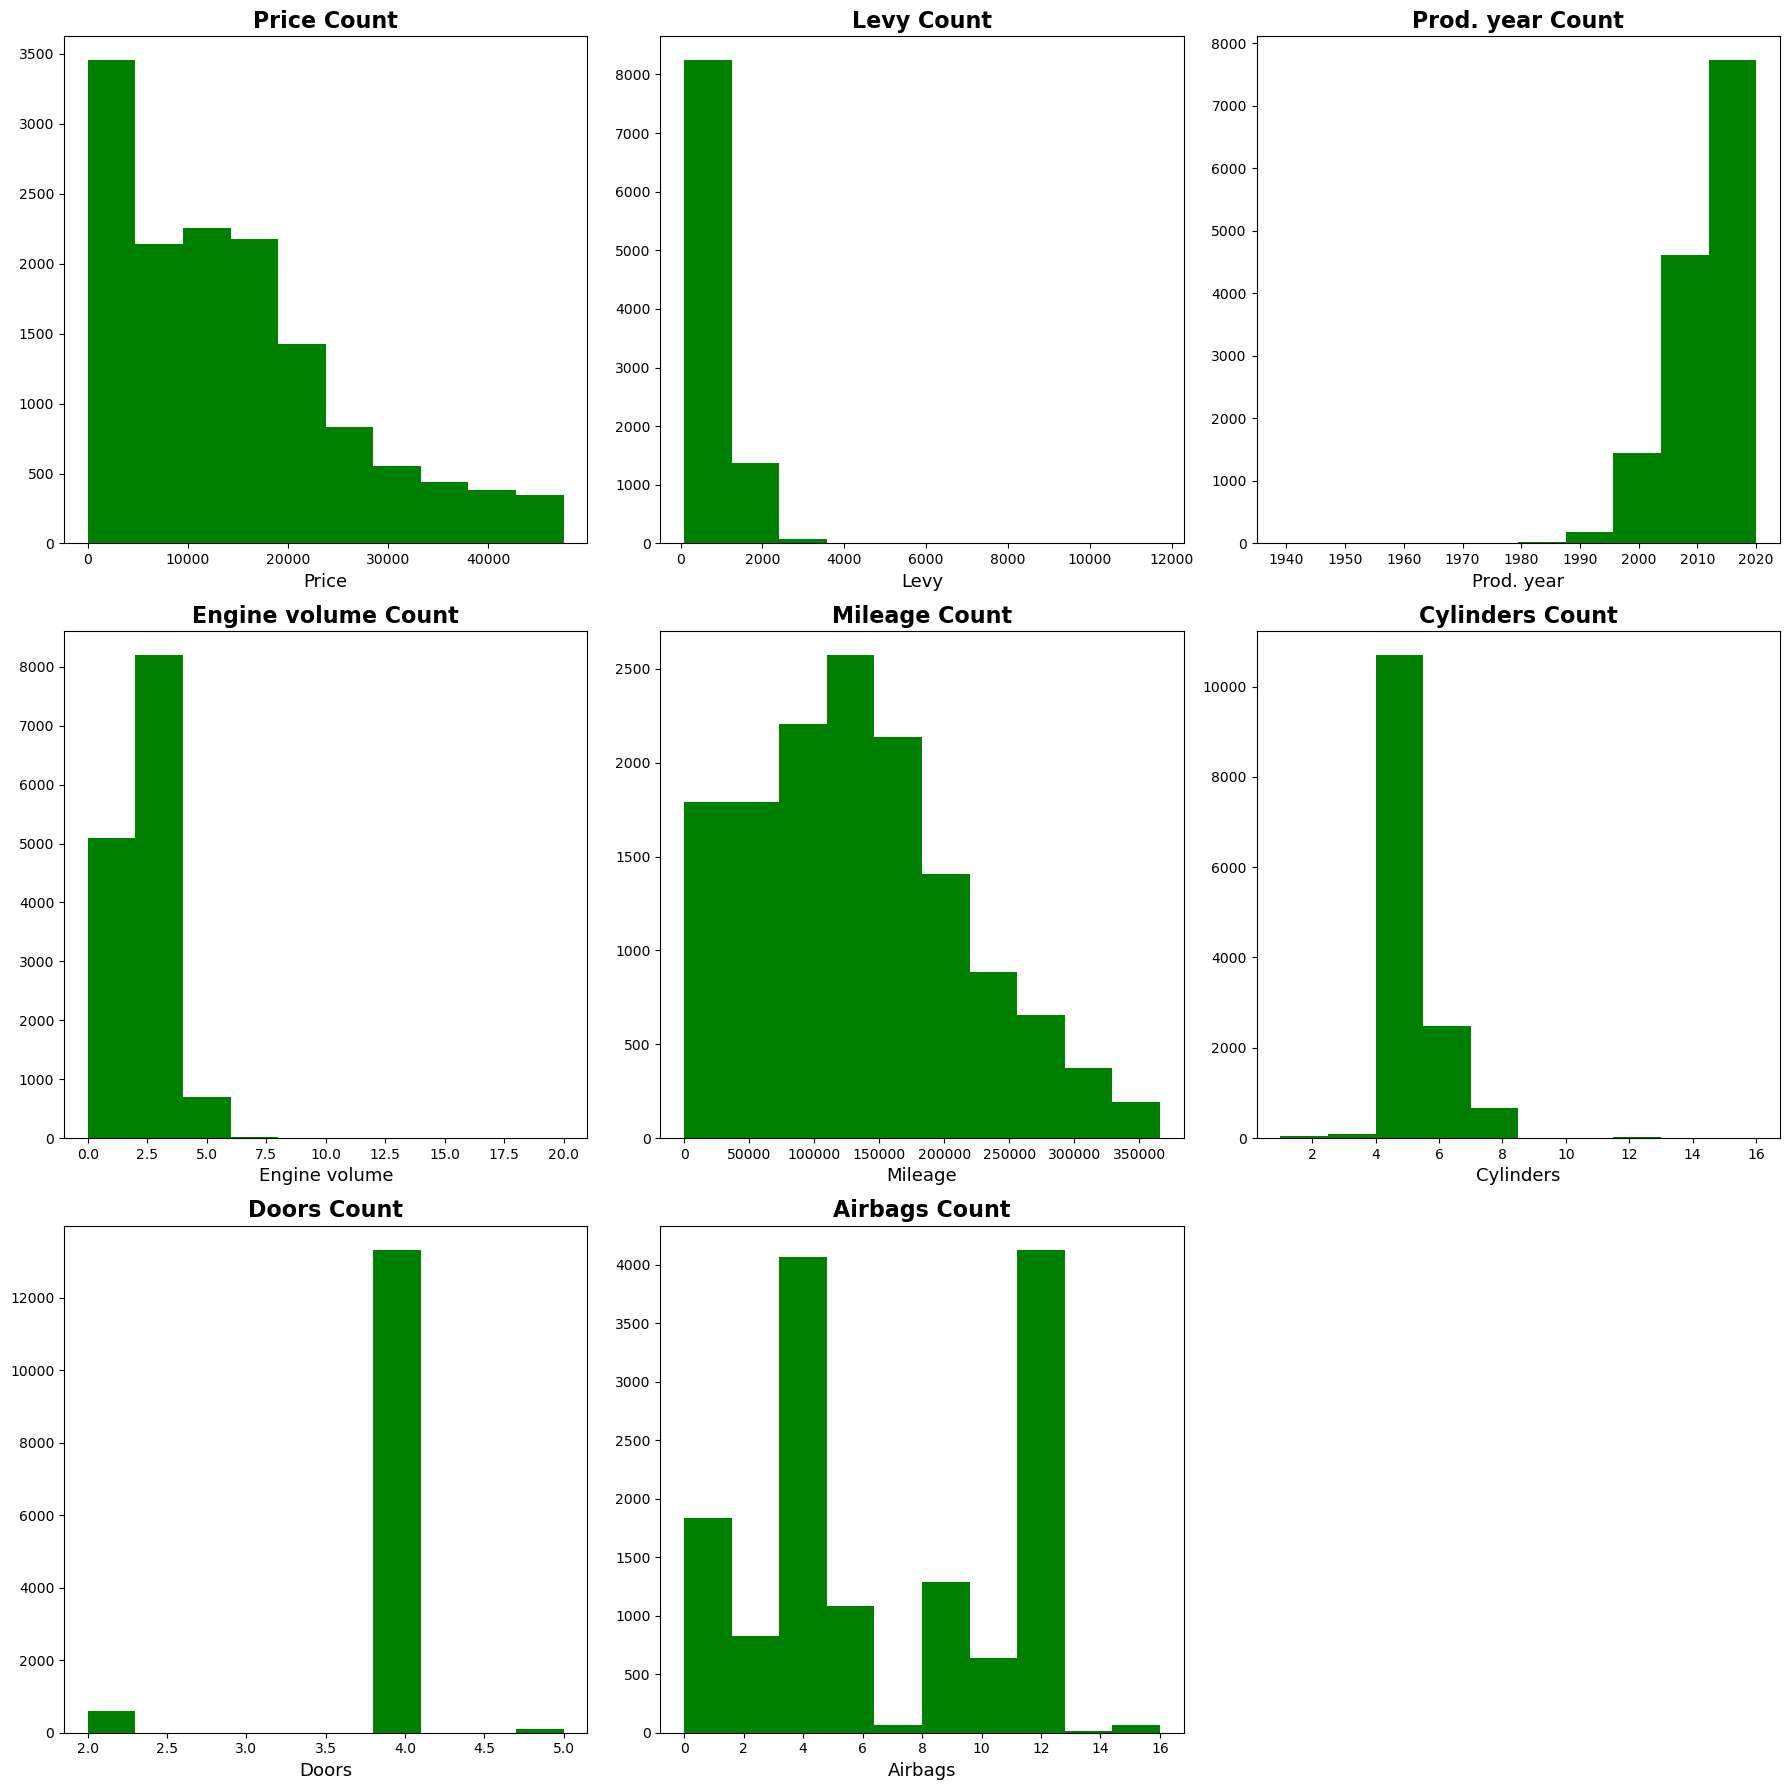

In [ ]:
plt.figure(figsize=(18,18))
fig.suptitle('Data Count After Outliers Removal', fontweight='bold', fontsize=18, y=1)

for i in range(8):
    # Create subplots (4 rows, 2 columns)
    ax = plt.subplot(3, 3, i + 1)
    # Display an image
    plt.hist(deleted_df[NUM_ATTRIBS[i]], color='Green')
    plt.title(NUM_ATTRIBS[i] + ' Count', fontweight='bold', fontsize=16)
    plt.xlabel(NUM_ATTRIBS[i], fontsize=13)


plt.tight_layout(h_pad=1.0)
plt.show()


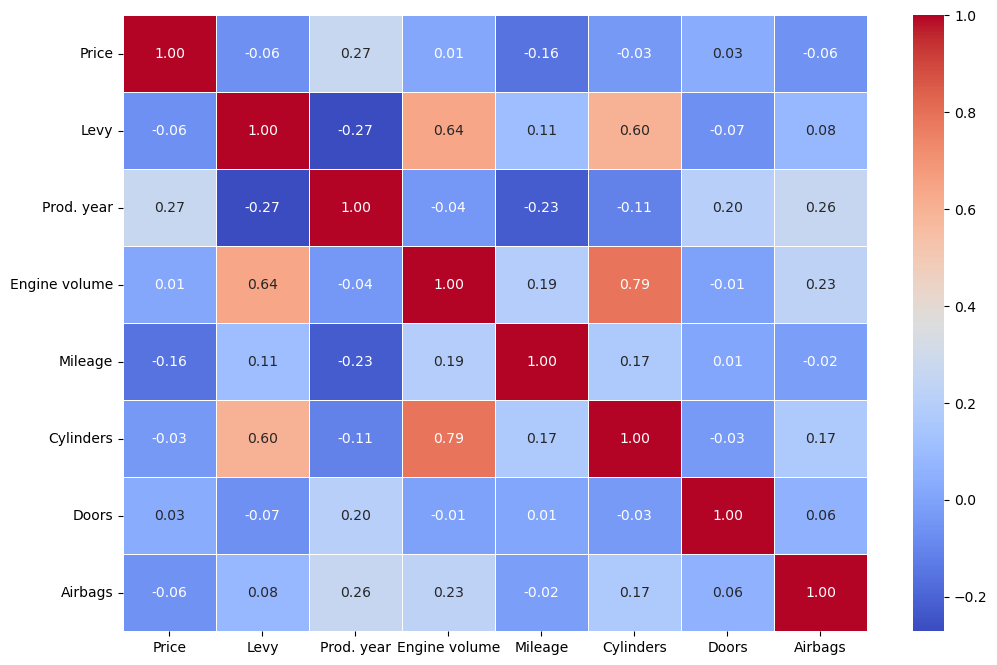

In [ ]:
corr = deleted_df[NUM_ATTRIBS].corr()

# Creating a heatmap for better visualization
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.heatmap(corr,
                 annot=True,
                 linewidths=0.5,
                 fmt='.2f',
                 cmap='coolwarm',
                 annot_kws={"size": 10});
ax.tick_params(labelsize=10);

Before we show the count of the Categorical attributes with respect to the price, we need to categorize the prices into less different unique values

In [ ]:
deleted_df["Price_cat"] = pd.cut(deleted_df["Price"],
                               bins=[0., 4000, 8000, 12000, 14000, 18000, np.inf],
                               labels=[1, 2, 3, 4, 5, 6])

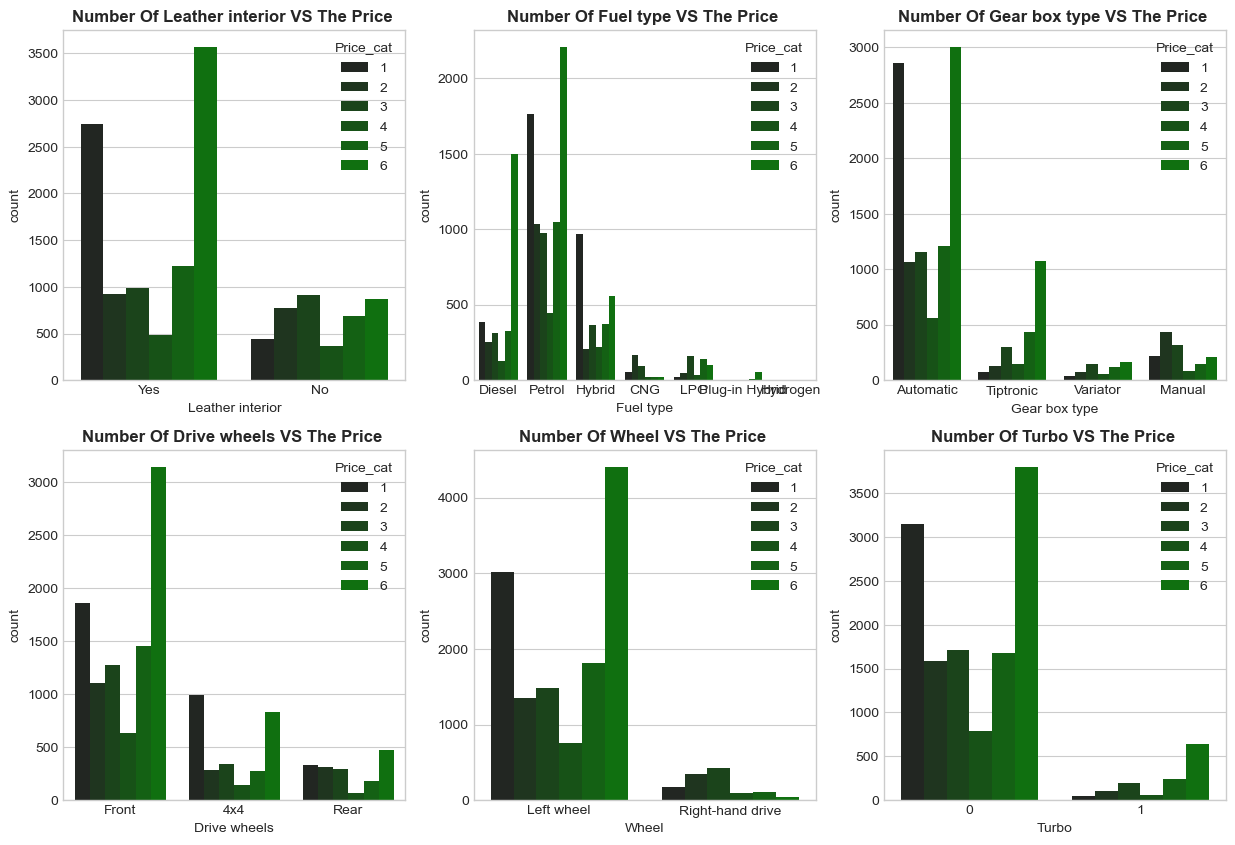

In [ ]:
attributes = CAT_ATTRIBS.copy()
attributes.remove('Model')
attributes.remove('Category')
attributes.remove('Manufacturer')
attributes.remove('Color')

# attributes = list(df.columns)
plt.style.use('seaborn-v0_8-whitegrid')

# Creating the figure
fig, axs = plt.subplots(2, 3, figsize=(15, 10), edgecolor='black')

for i in range(len(attributes)):
    row = i // 3
    col = i % 3
    sns.countplot(x=attributes[i],hue='Price_cat',data=deleted_df, ax=axs[row, col], palette='dark:g')
    axs[row, col].set_xlabel(attributes[i])
    axs[row, col].set_title(f'Number Of {attributes[i]} VS The Price ', weight='bold')

plt.show()


Features and Price seems to be very unrelated for the most of it

In [ ]:
df_eda.describe()

,ID,Price,Levy,Prod. year,Engine volume,Mileage,Cylinders,Doors,Airbags,Turbo
count,15389.000,15389.000,10724.000,15389.000,15389.000,15389.000,15389.000,15389.000,15389.000,15389.000
mean,45576051.326,18906.271,908.417,2010.894,2.310,1507132.214,4.586,3.924,6.588,0.100
std,920369.036,212829.059,460.999,5.624,0.875,47222900.775,1.200,0.407,4.319,0.300
min,20746880.000,1.000,87.000,1939.000,0.000,0.000,1.000,2.000,0.000,0.000
25%,45695043.000,5331.000,640.000,2009.000,1.800,70562.000,4.000,4.000,4.000,0.000
50%,45772290.000,13172.000,781.000,2012.000,2.000,126021.000,4.000,4.000,6.000,0.000
75%,45802039.000,22266.000,1058.000,2014.000,2.500,189000.000,4.000,4.000,12.000,0.000
max,45816654.000,26307500.000,11714.000,2020.000,20.000,2147483647.000,16.000,5.000,16.000,1.000


## Data Preprocessing

We're going to create a pipeline that:
1. Drop ID
2. Turn all `-` in the **Levy** column into median
3. Convert the non-interger/non-float numerical attributes and cleaning data:
* **Levy** - convert to int
* **Engine volume** - remove the word "Turbo" and convert to int
* **Mileage** - remove the metric 'km' and convert it to int
* **Doors** - change the data into the correct format
4. Encode all categorical attributes
4. Standardize to train our model better



**Note:** We dont remove the outliers in the pipeline because it wouldn't make sense to remove the test data's outliers. Therefore, outliers should be a separate action that can be done optionally, and will be done in this notebook.



In [ ]:
NUM_ATTRIBS = ['Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Doors', 'Cylinders', 'Airbags']
CAT_ATTRIBS = ['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type',
               'Gear box type', 'Drive wheels', 'Wheel', 'Color', 'Turbo']

In [ ]:
class DropID(BaseEstimator, TransformerMixin):
    '''
    A transformer to drop ID
    '''
    def __init__(self, drop=True):
        self.drop = drop
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        X = X.drop(['ID'], axis=1)

        return X

In [ ]:
class CustomImputer(BaseEstimator, TransformerMixin):
    '''
    A transformer to remove all instances with '-' in the Levy column if drop=True (default),
    or change to np.nan if drop=False
    '''
    def __init__(self):
        return
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        X['Levy'].replace({'-':np.nan}, inplace = True)

        return X

In [ ]:
class ConvertToNumerical(BaseEstimator, TransformerMixin):
    '''
    A transformer to convert 'Levy', 'Engine Volume', 'Mileage', and 'Doors' into clean
    and numeric data. Also, optionally remove_outliers for Levy, Price, and Mileage. We
    also add a new feature 'Turbo'.

    '''
    def __init__(self, remove_outliers=False):
        self.remove_outliers = remove_outliers
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        X['Levy'] = X['Levy'].astype('float64')
        X['Levy'].replace({np.nan:X['Levy'].median()}, inplace = True)
        X['Turbo'] = [(1 if len(s) > 3 else 0) for s in X['Engine volume']]
        X['Engine volume'] = np.array([s[:3] for s in X['Engine volume']]).astype(float)
        X['Mileage'] = np.array([s[:len(s) - 2] for s in X['Mileage']]).astype(int)
        X['Doors'].replace({'04-May':4, '02-Mar':2, '>5':5}, inplace=True)

        if self.remove_outliers:
            print('Removing Outliers in columns: Price, Levy, and Mileage')
            features = ['Price', 'Levy', 'Mileage']
            outliers = detect_outliers(X,features, 1.5)
            X.drop(X.loc[outliers].index,axis=0, inplace=True)

        return X

In [ ]:
class ConvertToFloat(BaseEstimator, TransformerMixin):
    '''
    Converts all columns to float
    '''
    def __init__(self, remove_outliers=False):
        self.remove_outliers = remove_outliers
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        for i in NUM_ATTRIBS:
            X[i] = X[i].astype(float)
        return X

In [ ]:
# NUM ATTRIBUTES
pipeline_numerical_unstandardized = Pipeline([
    ('drop_id', DropID()),
    ('custom_imputer', CustomImputer()),
    ('convert_to_numerical', ConvertToNumerical()),
])

pipline_numerical_standardize = ColumnTransformer([
    ('standardize', StandardScaler(), NUM_ATTRIBS)
], remainder='passthrough')


names = ['Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Doors', 'Cylinders', 'Airbags', 'Price',
         'Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels',
        'Wheel', 'Color', 'Turbo']

# Note: we have to separate standardizing and cleaning because when we clean, we can remove
# some instances in some cases. Changing shapes in ColumnTransformer doesn't work, but we need
# ColumnTransformer for StandardScaler(). Therefore, we make sure to do any instances changes before
pipeline_numerical_full = Pipeline([
    ('cleaning_numeric', pipeline_numerical_unstandardized),
    ('standardize',pipline_numerical_standardize),
    ("pandarizer", FunctionTransformer(lambda x: pd.DataFrame(x, columns = names))),
    ('reconvert_to_float', ConvertToFloat())
    # pandas is buggy and requires each column to be converted to float again for some reason, or else the
    # dtype will be 'object'
])


# ====================================================================================================

# CATEGORICAL ATTRIBUTES
pipeline_cat_full = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown='ignore'), CAT_ATTRIBS),
    ], remainder='passthrough')

## Splitting Data into X & y

In [ ]:
def full_pipeline(df, training=False):
    '''
    Cleans the data and add a new feature. Outliers will be removed if it's the training data. It will
    return the X and y in a tuple.
    '''
    if training:
        new_df = pipeline_numerical_full.set_params(
                                            cleaning_numeric__convert_to_numerical__remove_outliers=True).fit_transform(df)
        X = new_df.drop('Price', axis = 1)
        encoded_X = pipeline_cat_full.fit_transform(X)

    else:
        new_df = pipeline_numerical_full.transform(df)
        X = new_df.drop('Price', axis = 1)
        encoded_X = pipeline_cat_full.transform(X)

    y = new_df['Price']

    return encoded_X, y


In [ ]:
X_train, y_train = full_pipeline(df_train, training=True)
X_test, y_test = full_pipeline(df_test)

Removing Outliers in columns: Price, Levy, and Mileage
Removing Outliers in columns: Price, Levy, and Mileage


In [ ]:
X_train, y_train, X_test, y_test = X_train.astype(float), y_train.astype(float), X_test.astype(float), y_test.astype(float)

## Modelling

In [ ]:
def fit_and_score(models, X_train, y_train, X_test=None, y_test=None, evaluate_test=False):
    """
    Fits and evaluates given machine learning models. Evaluates the model on the training data by default.
    If the test sets are given and evaluate_test is set to be True, the model will be evaluated on the test set.

    models : a dict of different Scikit-Learn machine models
    X_train : training data (no labels)
    y_train : training labels
    X_test : testing data (no labels)
    y_test : test labels
    evaluate_test : Boolean value, determines if the model will be evaluated on the test set or training set
    """

    # Make a list to keep model scores
    model_scores = []

    # Loop through models
    for name, model in models.items():

        # Fit the model to the data
        model.fit(X_train, y_train)

        # Predict
        if evaluate_test:
            y_pred = model.predict(X_test)
            y = y_test
        else:
            y_pred = model.predict(X_train)
            y = y_train

        # Evaluate the model's scores and store to model_various_scores
        model_various_scores = [name, np.sqrt(mean_squared_error(y, y_pred)), mean_squared_error(y, y_pred),
                                r2_score(y, y_pred), mean_absolute_error(y, y_pred),
                                mean_absolute_percentage_error(y, y_pred)
                               ]

        # Append model_various_scores to model_scores
        model_scores.append(model_various_scores)

    df_scores = pd.DataFrame(model_scores, columns=['Models', 'RMSE', 'MSE', 'R2', 'MAE', 'MAPE'])
    df_scores.MAPE = df_scores.MAPE.round(3).astype(str) + '%'
    df_scores.set_index('Models', inplace=True)
    df_scores.sort_values(by=['RMSE'], ascending=True, inplace=True);
    df_scores.columns = pd.MultiIndex.from_product([[f"Scores of Models Evaluated on {'Test' if evaluate_test else 'Training'} set"], df_scores.columns])

    return df_scores

In [ ]:
%%time
# Put models in a dictionary
model = {
            "Linear Regression": LinearRegression(),
            "Ridge Regression": Ridge(),
            "SGD Regressor": SGDRegressor(),
            "Lasso": Lasso(),
            "Elastic": ElasticNet(),
            "LinearSVR": LinearSVR(),
            "SVR rbf": SVR(),
            "Decision Tree Regressor": DecisionTreeRegressor(),
            "K-nearest neighbours": KNeighborsRegressor()
        }

# Call function to evaluate the models
model_comparison_scores = fit_and_score(models=model,
                                X_train=X_train,
                                y_train=y_train)

/Users/justinjonany/Desktop/python/data-science/books/Hands_On_Machine_Learning/env/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


CPU times: user 47.9 s, sys: 508 ms, total: 48.4 s
Wall time: 23.3 s


In [ ]:
model_comparison_scores

Scores of Models Evaluated on Training set  \
                                                              RMSE   
Models                                                               
Decision Tree Regressor                                    598.950   
K-nearest neighbours                                      5078.525   
Linear Regression                                         7620.688   
Ridge Regression                                          7727.788   
Lasso                                                     7861.910   
SGD Regressor                                             8074.549   
Elastic                                                   9796.561   
LinearSVR                                                10974.617   
SVR rbf                                                  11267.003   

                                                               
                                  MSE    R2      MAE     MAPE  
Models                                                         
Decision Tree Regressor    358740.686 0.997   59.616   0.091%  
K-nearest neighbours     25791414.144 0.798 3209.585   7.711%  
Linear Regression        58074887.096 0.544 5579.428  12.682%  
Ridge Regression         59718710.372 0.531 5806.536   12.88%  
Lasso                    61809633.075 0.515 5977.315  13.102%  
SGD Regressor            65198339.142 0.488 6139.971   13.45%  
Elastic                  95972600.321 0.247 7505.276  16.298%  
LinearSVR               120442220.324 0.055 8250.900  13.393%  
SVR rbf                 126945351.259 0.004 8802.188   16.61%

Our Decision Tree Regressor aseems to be performing awfully well. However, decision trees are known to overfit. Let's evaluate their cross validation scores!

## Baseline Model 1 - Decision Trees

In [ ]:
dtr = DecisionTreeRegressor()
dtr_cv_score = cross_val_score(dtr, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

In [ ]:
print('Decision Tree Regressor RMSE: ', np.sqrt(-dtr_cv_score).mean())

Decision Tree Regressor RMSE:  6923.18774047848


Now this makes more sense, let's select the Decision Tree as our first Baseline model

### Hyperparameter Tuning

In [ ]:
params_dt = {
    'min_samples_split': np.arange(2, 50, 2),
    'min_samples_leaf': np.arange(2, 50, 2),
    'max_features': ['sqrt', 'log2', None],
    'max_depth': np.append(np.arange(4, 64, 4), np.array(None)),
}

rs_dt = RandomizedSearchCV(dtr,
                           params_dt,
                           cv=5,
                           n_iter=50,
                           verbose=1,
                           scoring='neg_mean_squared_error')

In [ ]:
rs_dt.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=50,
                   param_distributions={'max_depth': array([4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, None],
      dtype=object),
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48])},
                   scoring='neg_mean_squared_error', verbose=1)

In [ ]:
rs_dt.best_params_

{'min_samples_split': 30,
 'min_samples_leaf': 6,
 'max_features': None,
 'max_depth': 56}

In [ ]:
np.sqrt(-rs_dt.best_score_)

6490.715409143352

We made a slight improvement

## Baseline Model 2 - K-nearest-neighbours

In [ ]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
knn_cv_score = cross_val_score(knn, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

In [ ]:
print('Decision Tree Regressor RMSE: ', np.sqrt(-knn_cv_score).mean())

Decision Tree Regressor RMSE:  6479.302824038811


It seems to perform slightly better than decision trees

### Hyperparameter Tuning

In [ ]:
params_knn = {
    'n_neighbors': np.arange(2, 20, 1),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': np.arange(8, 60, 2)
}

rs_knn = RandomizedSearchCV(knn,
                           params_knn,
                           cv=5,
                           n_iter=50,
                           verbose=1,
                           scoring='neg_mean_squared_error')

In [ ]:
rs_knn.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=KNeighborsRegressor(), n_iter=50,
                   param_distributions={'leaf_size': array([ 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40,
       42, 44, 46, 48, 50, 52, 54, 56, 58]),
                                        'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   scoring='neg_mean_squared_error', verbose=1)

In [ ]:
rs_knn.best_params_

{'weights': 'distance', 'p': 1, 'n_neighbors': 12, 'leaf_size': 24}

In [ ]:
np.sqrt(-rs_knn.best_score_)

6065.460478211505

## Ensemble Methods
Let's create ensemble methods with Decision Trees

We're going to use:
1. Random Forest Regressor
2. Extra Trees
3. Adaboost
4. XGBoost
5. Blending Algorithm


### 1. Random Forest Regressor

In [ ]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
rfr_cv_score = cross_val_score(rfr, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

In [ ]:
print('Random Forest Regressor RMSE: ', np.sqrt(-rfr_cv_score).mean())

Random Forest Regressor RMSE:  5346.870149271401


Wow it's already way better than our baseline model

In [ ]:
params_rfr = {
    'min_samples_split': np.arange(2, 50, 3),
    'min_samples_leaf': np.arange(2, 50, 3),
    'max_features': ['sqrt', 'log2', None],
    'max_depth': np.append(np.arange(6, 64, 4), np.array(None)),
    'n_estimators':np.arange(50, 250, 25),
}

rs_rfr = RandomizedSearchCV(rfr,
                            params_rfr,
                            cv=5,
                            n_iter=30,
                            verbose=1,
                            scoring='neg_mean_squared_error')

In [ ]:
rs_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=30,
                   param_distributions={'max_depth': array([6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, None],
      dtype=object),
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': array([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47]),
                                        'min_samples_split': array([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47]),
                                        'n_estimators': array([ 50,  75, 100, 125, 150, 175, 200, 225])},
                   scoring='neg_mean_squared_error', verbose=1)

In [ ]:
rs_rfr.best_params_

{'n_estimators': 150,
 'min_samples_split': 41,
 'min_samples_leaf': 2,
 'max_features': None,
 'max_depth': 30}

In [ ]:
np.sqrt(-rs_rfr.best_score_)

5873.918231167651

We found that the **default hyperparameters** perform the best for Random Forest Regressor

### 2. Extra Trees

Let's try ExtraTreeRegressor, a similar algorithm to the RandomForestRegressor, but with more randomnessm. In some cases, it might perform better

In [ ]:
etr = ExtraTreesRegressor(bootstrap=True)
etr.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=True)

In [ ]:
etr_cv_score = cross_val_score(etr, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

In [ ]:
print('Extra Tree Regressor RMSE: ', np.sqrt(-etr_cv_score).mean())

Extra Tree Regressor RMSE:  5425.093538075137


In [ ]:
params_et = {
    'min_samples_split': np.arange(2, 50, 3),
    'min_samples_leaf': np.arange(2, 50, 3),
    'max_features': ['sqrt', 'log2', None],
    'max_depth': np.append(np.arange(6, 64, 4), np.array(None)),
    'n_estimators':np.arange(50, 250, 25),
    'bootstrap': [True, False]
}

rs_etr = RandomizedSearchCV(etr,
                            params_et,
                            cv=5,
                            n_iter=30,
                            verbose=1,
                           scoring='neg_mean_squared_error')

In [ ]:
rs_etr.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=ExtraTreesRegressor(bootstrap=True),
                   n_iter=30,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, None],
      dtype=object),
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': array([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47]),
                                        'min_samples_split': array([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47]),
                                        'n_estimators': array([ 50,  75, 100, 125, 150, 175, 200, 225])},
                   scoring='neg_mean_squared_error', verbose=1)

In [ ]:
rs_etr.best_params_

{'n_estimators': 50,
 'min_samples_split': 47,
 'min_samples_leaf': 14,
 'max_features': None,
 'max_depth': 54,
 'bootstrap': False}

In [ ]:
np.sqrt(-rs_etr.best_score_)

6242.569805220423

We found that the **default hyperparameters** perform the best for Extra Trees

### 3. Adaboost
We're sticking with DecisionTrees as the base estimator

In [ ]:
abr = AdaBoostRegressor(DecisionTreeRegressor())
abr.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor())

In [ ]:
abr_cv_score = cross_val_score(abr, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

In [ ]:
print('AdaBoost Regressor RMSE: ', np.sqrt(-abr_cv_score).mean())

AdaBoost Regressor RMSE:  5441.843716211098


In [ ]:
params_abr = {
    'estimator': [DecisionTreeRegressor(max_depth=i) for i in range(1,25)],
    'n_estimators': np.arange(50, 300, 50),
    'learning_rate': np.arange(0.1, 1.1, 0.1),
    'loss': ['linear', 'square', 'exponential'],
}

rs_abr = RandomizedSearchCV(abr,
                            params_abr,
                            cv=5,
                            n_iter=30,
                            verbose=1,
                           scoring='neg_mean_squared_error')

In [ ]:
rs_abr.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor()),
                   n_iter=30,
                   param_distributions={'estimator': [DecisionTreeRegressor(max_depth=1),
                                                      DecisionTreeRegressor(max_depth=2),
                                                      DecisionTreeRegressor(max_depth=3),
                                                      DecisionTreeRegressor(max_depth=4),
                                                      DecisionTreeRegressor(max_depth=5),
                                                      DecisionTreeRegressor(max_depth=6),
                                                      DecisionT...
                                                      DecisionTreeRegressor(max_depth=20),
                                                      DecisionTreeRegressor(max_depth=21),
                                                      DecisionTreeRegressor(max_depth=22),
                                                      DecisionTreeRegressor(max_depth=23),
                                                      DecisionTreeRegressor(max_depth=24)],
                                        'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': array([ 50, 100, 150, 200, 250])},
                   scoring='neg_mean_squared_error', verbose=1)

In [ ]:
rs_abr.best_params_

{'n_estimators': 150,
 'loss': 'linear',
 'learning_rate': 0.7000000000000001,
 'estimator': DecisionTreeRegressor(max_depth=22)}

In [ ]:
np.sqrt(-rs_abr.best_score_)

5328.895736366722

### 4. XGBoost

In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
xgb_cv_score = cross_val_score(xgb, X_train, y_train, cv=5, scoring="neg_mean_squared_error")

In [ ]:
print('XGBoost Regressor RMSE: ', np.sqrt(-xgb_cv_score).mean())

XGBoost Regressor RMSE:  5772.2165317196905


In [ ]:
params_xgb = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': np.arange(3, 25, 1),
#     'grow_policy': ['depthwise', 'lossguide'],
    'eta': np.arange(0.05, 1.05, 0.05),
    'subsample': np.arange(0.2, 1.1, 0.1)
}

rs_xgb = RandomizedSearchCV(xgb,
                            params_xgb,
                            cv=5,
                            n_iter=30,
                            verbose=1,
                           scoring='neg_mean_squared_error')

In [ ]:
rs_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   n_iter=30,
                   param_distributions={'eta': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250]),
                                        'subsample': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   scoring='neg_mean_squared_error', verbose=1)

In [ ]:
rs_xgb.best_params_

{'subsample': 0.8000000000000003,
 'n_estimators': 50,
 'max_depth': 14,
 'eta': 0.2}

In [ ]:
np.sqrt(-rs_xgb.best_score_)

5383.790779240315

### 5. Blending Algorithm
Blending is an ensemble machine learning technique that uses a machine learning model to learn how to best combine the predictions from multiple contributing ensemble member models.

The architecture of a stacking model involves two or more base models, often referred to as level-0 models, and a meta-model that combines the predictions of the base models, referred to as a level-1 model. The meta-model is trained on the predictions made by base models on out-of-sample data.

* Level-0 Models (Base-Models): Models fit on the training data and whose predictions are compiled.
* Level-1 Model (Meta-Model): Model that learns how to best combine the predictions of the base models.

Here, I'm going to implement the level-0 with the following base models:
- Linear Regression
- SVR
- K-Nearest Neighbour Regression
- Random Forest Regressor
- XGBoost
- AdaBoost

It's best to use models that have different predictive methods


Finally, I'm going to use a linear regression to learn to combine the prediction of the base models (**the blender**)

**Note:** For my implementation, I'll making it 2 layers (levels), but it's definitely possible to create multiple layers of blenders

Before starting, I need to split the training set into a subset used to train the base models and a subset used to train the meta-model.

**Note:** the validation set is often referred to as the hold-out set

In [ ]:
X_train_blend, X_val_blend, y_train_blend, y_val_blend = train_test_split(X_train, y_train, test_size=0.33)
X_train_blend.shape, X_val_blend.shape, y_train_blend.shape, y_val_blend.shape

((7862, 1287), (3873, 1287), (7862,), (3873,))

#### First Layer
Training the models and combining the predictions

In [ ]:
def get_models():
    models = list()
    models.append(('lr', LinearRegression()))
    models.append(('knn', KNeighborsRegressor()))
    models.append(('svm', SVR()))
    models.append(('rfr', RandomForestRegressor()))
    models.append(('xgb', XGBRegressor()))
    models.append(('abr', AdaBoostRegressor()))
    return models

In [ ]:
def prediction_combiner(models, X_train_b, X_val_b, y_train_b, y_val_b):
    '''
    Fits X_train and y_train into models and create predictions on X_val. The results will be combined
    into a matrix, which will be used to train the blender. The function returns the trained blender.
    '''

    # To Hold all the predictions
    meta_X = list()

    for name, model in models:
        # Train on the training set
        model.fit(X_train_b, y_train_b)

        # Predict on hold-out set
        y_pred = model.predict(X_val_b)
        y_pred = y_pred.reshape(len(y_pred), 1) # To combine all the data into meta_X
        meta_X.append(y_pred)

    meta_X = np.hstack(meta_X) # Shapes meta_X into the correct format for training data
    return meta_X

#### Second Layer
Making predictions

In [ ]:
def predict_ensemble(models, blender, X_test):
    '''
    Returns the predictions of X_test using the blender
    '''
    # We need to create the meta_X from the models we already trained
    meta_X = list()
    for name, model in models:
        y_pred = model.predict(X_test)
        y_pred = y_pred.reshape(len(y_pred), 1) # To combine all the data into meta_X
        meta_X.append(y_pred)

    meta_X = np.hstack(meta_X)

    return blender.predict(meta_X)


#### Using the blending algorithm

In [ ]:
models = get_models()
meta_X = prediction_combiner(models, X_train_blend, X_val_blend, y_train_blend, y_val_blend)
blender = LinearRegression()
blender.fit(meta_X, y_val_blend)
y_pred = predict_ensemble(models, blender, X_train)

blending_score = np.sqrt(mean_squared_error(y_train, y_pred))

print('Blending RMSE: ', blending_score)


Blending RMSE:  3740.000917549679


### Turning it into a custom blending estimator

In [ ]:
class Blending(RegressorMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y, models):
        X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X, y, test_size=0.33)

        meta_X = list()

        for name, model in models:
            # Train on the training set
            model.fit(X_train_b, y_train_b)

            # Predict on hold-out set
            y_pred = model.predict(X_val_b)
            y_pred = y_pred.reshape(len(y_pred), 1) # To combine all the data into meta_X
            meta_X.append(y_pred)

        meta_X = np.hstack(meta_X) # Turning into the correct format

        self.blender = LinearRegression() # Our blender / meta-model
        self.blender.fit(meta_X, y_val_b)

        return self

    def predict(self, X):
        # We need to create the meta_X from the models we already trained
        meta_X = list()
        for name, model in models:
            y_pred = model.predict(X)
            y_pred = y_pred.reshape(len(y_pred), 1) # To combine all the data into meta_X
            meta_X.append(y_pred)

        meta_X = np.hstack(meta_X)
        return self.blender.predict(meta_X)

In [ ]:
bl = Blending()

In [ ]:
bl.fit(X_train, y_train, get_models())

Blending()

In [ ]:
y_pred = bl.predict(X_train)
bl_score = np.sqrt(mean_squared_error(y_train, y_pred))
print('Blending RMSE: ', bl_score)

Blending RMSE:  3792.000652121394


## Evaluation

In [ ]:
def evaluate_scores(trained_models, X, y):
    """
    Evaluates the trained_models in various metrics, and returns a dataframe of the results

    """

    # Make a list to keep model scores
    model_scores = []

    # Loop through models
    for name, model in trained_models.items():
        y_pred = model.predict(X)

        # Evaluate the model's scores and store to model_various_scores
        model_various_scores = [name, np.sqrt(mean_squared_error(y, y_pred)), mean_squared_error(y, y_pred),
                                r2_score(y, y_pred), mean_absolute_error(y, y_pred),
                                mean_absolute_percentage_error(y, y_pred)
                               ]

        # Append model_various_scores to model_scores
        model_scores.append(model_various_scores)

    df_scores = pd.DataFrame(model_scores, columns=['Models', 'RMSE', 'MSE', 'R2', 'MAE', 'MAPE'])
    df_scores.MAPE = df_scores.MAPE.round(3).astype(str) + '%'
    df_scores.set_index('Models', inplace=True)
    df_scores.sort_values(by=['RMSE'], ascending=True, inplace=True);
    df_scores.columns = pd.MultiIndex.from_product([[f"Scores of Models"], df_scores.columns])

    return df_scores

In [ ]:
%%time
# Put models in a dictionary
model = {
            'K-nearest-neighbor': knn,
            'Random Forest Regressor': rfr,
            'Extra Tree': etr,
            'Adaboost': abr,
            'XGBoost': xgb,
            'Blender': bl,
            'Hyperparameter Tuned Random Forest Regressor': rs_knn,
            'Hyperparameter Tuned Random Forest Regressor': rs_rfr,
            'Hyperparameter Tuned Extra Tree': rs_etr,
            'Hyperparameter Tuned Adaboost': rs_abr,
            'Hyperparameter Tuned XGBoost': rs_xgb,
        }

# Call function to evaluate the models
model_comparison_scores = evaluate_scores(model, X_test, y_test)

CPU times: user 17.3 s, sys: 1.68 s, total: 19 s
Wall time: 3.32 s


In [ ]:
model_comparison_scores

Scores of Models               \
                                                         RMSE          MSE   
Models                                                                       
Hyperparameter Tuned Adaboost                        5230.980 27363156.766   
Extra Tree                                           5250.098 27563528.172   
Random Forest Regressor                              5298.111 28069979.465   
Adaboost                                             5307.773 28172456.174   
Hyperparameter Tuned XGBoost                         5346.588 28586000.166   
Blender                                              5423.940 29419129.413   
XGBoost                                              5637.003 31775801.372   
Hyperparameter Tuned Random Forest Regressor         5728.566 32816464.166   
Hyperparameter Tuned Extra Tree                      5923.107 35083194.913   
K-nearest-neighbor                                   6173.314 38109810.804   

                                                                      
                                                R2      MAE     MAPE  
Models                                                                
Hyperparameter Tuned Adaboost                0.779 3256.853   13.77%  
Extra Tree                                   0.778 3154.706  13.129%  
Random Forest Regressor                      0.774 3147.542  13.652%  
Adaboost                                     0.773 3041.705  12.826%  
Hyperparameter Tuned XGBoost                 0.769 3279.705   13.87%  
Blender                                      0.763 3377.160  13.623%  
XGBoost                                      0.744 3793.029  13.255%  
Hyperparameter Tuned Random Forest Regressor 0.735 3743.745  14.644%  
Hyperparameter Tuned Extra Tree              0.717 3982.627  14.005%  
K-nearest-neighbor                           0.693 3975.319  12.369%

In [ ]:
print(f"Our best model is {model_comparison_scores.index[0]} with a final RMSE score of {model_comparison_scores['Scores of Models', 'RMSE'][0]}")

Our best model is Hyperparameter Tuned Adaboost with a final RMSE score of 5230.980478423107


In [ ]:
dump(model[model_comparison_scores.index[0]], filename="final_model.joblib")

['final_model.joblib']